In [1]:
import pandas as pd
import random


In [2]:
p = 0.01  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         'query_file.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)

In [3]:
df['category_id'] = df['Label'].factorize()[0]
category_id_df = df[['Label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)
df.head()

,Label,Query,category_id
0,abruzzo,absolute bangla suites phuket,0
1,abruzzo,abstract strategy,0
2,academic conferences & publications,academic editing service,1
3,academic conferences & publications,academic publications search,1
4,acapulco,accessories for cars interior,2


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [6]:
features = tfidf.fit_transform(df.Query).toarray()
labels = df.category_id
features.shape

(11042, 1971)

In [7]:
from sklearn.feature_selection import chi2
import numpy as np

In [8]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("# '{}':".format(Product))
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['Query'], df['Label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [11]:
print(clf.predict(count_vect.transform(["animated films"])))

print(clf.predict(count_vect.transform(["acapulco information"])))

print(clf.predict(count_vect.transform(["amsterdam"])))

print(clf.predict(count_vect.transform(["better racing"])))

print(clf.predict(count_vect.transform(["body spa"])))

print(clf.predict(count_vect.transform(["hotel"])))

['bermuda']
['infiniti']
['bermuda']
['bermuda']
['bermuda']
['hosted data storage']


In [12]:
df[df['Query'] == "acapulco information"]


,Label,Query,category_id


In [13]:
df[df['Query'] == "access locksmith"]

,Label,Query,category_id


In [14]:
print(clf.predict(count_vect.transform(["animated films"])))



['bermuda']


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\users\chloe\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\chloe\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\chloe\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\chloe\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_

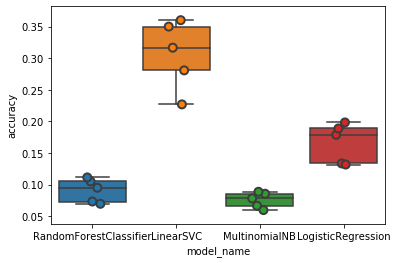

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

In [17]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.306827
LogisticRegression        0.166276
MultinomialNB             0.075802
RandomForestClassifier    0.090927
Name: accuracy, dtype: float64

In [18]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [21]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)



In [22]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Label', 'Query']])
      print('')

IndexError: index 1578 is out of bounds for axis 0 with size 1578

In [23]:
model.fit(features, labels)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [24]:
from sklearn.feature_selection import chi2

N = 2
for Label, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
#   print("# '{}':".format(Label))
#   print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
#   print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


In [25]:
from sklearn import metrics


In [26]:
print(metrics.classification_report(y_test, y_pred, labels.unique(), target_names=df['Label'].unique()))

                                              precision    recall  f1-score   support

                                     abruzzo       0.00      0.00      0.00         0
         academic conferences & publications       0.00      0.00      0.00         0
                                    acapulco       0.00      0.00      0.00         1
              accident & personal injury law       0.00      0.00      0.00         1
                       accounting & auditing       0.00      0.00      0.00         0
             accounting & financial software       0.00      0.00      0.00         5
                            acting & theater       0.00      0.00      0.00         0
                              action figures       0.00      0.00      0.00         1
                     action & platform games       0.00      0.00      0.00         2
                                       acura       0.75      1.00      0.86         3
                                  add & adhd       0.

c:\users\chloe\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chloe\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
